In [42]:
import math
import numpy as np
import sys
import time

#3rd party modules
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import c
from astropy.io import fits
import getpass
from halotools.mock_observables import angular_tpcf
from scipy import integrate, interpolate
from scipy.stats import poisson
    
#Plot
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm, ticker, patches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
## default setting
fig_width_pt = 900                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

def log_10_product(x, pos):
    return '%1g' % (x)

formatter = ticker.FuncFormatter(log_10_product)
%config InlineBackend.figure_format = 'retina'

In [43]:
#Reading in the data

halos = fits.open('MICE2lightcone_halos_Mh13.5above_z0.35.fits')[1].data
print(halos.shape[0])
print(halos['z_cgal_v'])

gws = fits.open('MICE2lightcone_gwhalos_Mh12.5_z0.35.fits')[1].data
print(gws.shape[0])

rand_halos = np.load('MICE2lightcone_rand_halos_Mh13.5above_z0.35.npy')

7804244
[0.16337 0.30527 0.33748 ... 0.16761 0.1341  0.12919]
18041259


In [44]:
#compute luminosity distance versus z_red relation
cp = FlatLambdaCDM(H0=70, Om0=0.25)

numz = 501
a_zred = np.array([iz/numz for iz in range(501)])
a_dL = cp.luminosity_distance(a_zred).value

func_zred_to_dL = interpolate.InterpolatedUnivariateSpline(a_zred, a_dL)
func_dL_to_zred = interpolate.InterpolatedUnivariateSpline(a_dL, a_zred)

In [45]:
zlow = func_dL_to_zred(200)#originally at 1600
zhigh = func_dL_to_zred(1400)

#selected in redshift space
mask = (gws['z_cgal_v']>=zlow) & (gws['z_cgal_v']<zhigh)
print('gw {0:4.3f} <= z_red < {1:4.3f}'.format(zlow, zhigh))
print('mean gw z_red = {0:4.3f}'.format(np.mean(gws[mask]['z_cgal_v'])))

tmp_idx = np.random.randint(1, gws[mask].shape[0], size=5100)
tmp_gws = gws[mask][tmp_idx]
print('# of selected gws = {0}'.format(tmp_gws.shape[0]))

#halo_mask = (halos['z_cgal_v']>=0.0125) & (halos['z_cgal_v']<3.0125)
#tmp_halos = halos[halo_mask]
#print('# of selected halos = {0}'.format(tmp_halos.shape[0]))

gw 0.045 <= z_red < 0.272
mean gw z_red = 0.187
# of selected gws = 5100


computation took 7.534027099609375e-05 seconds


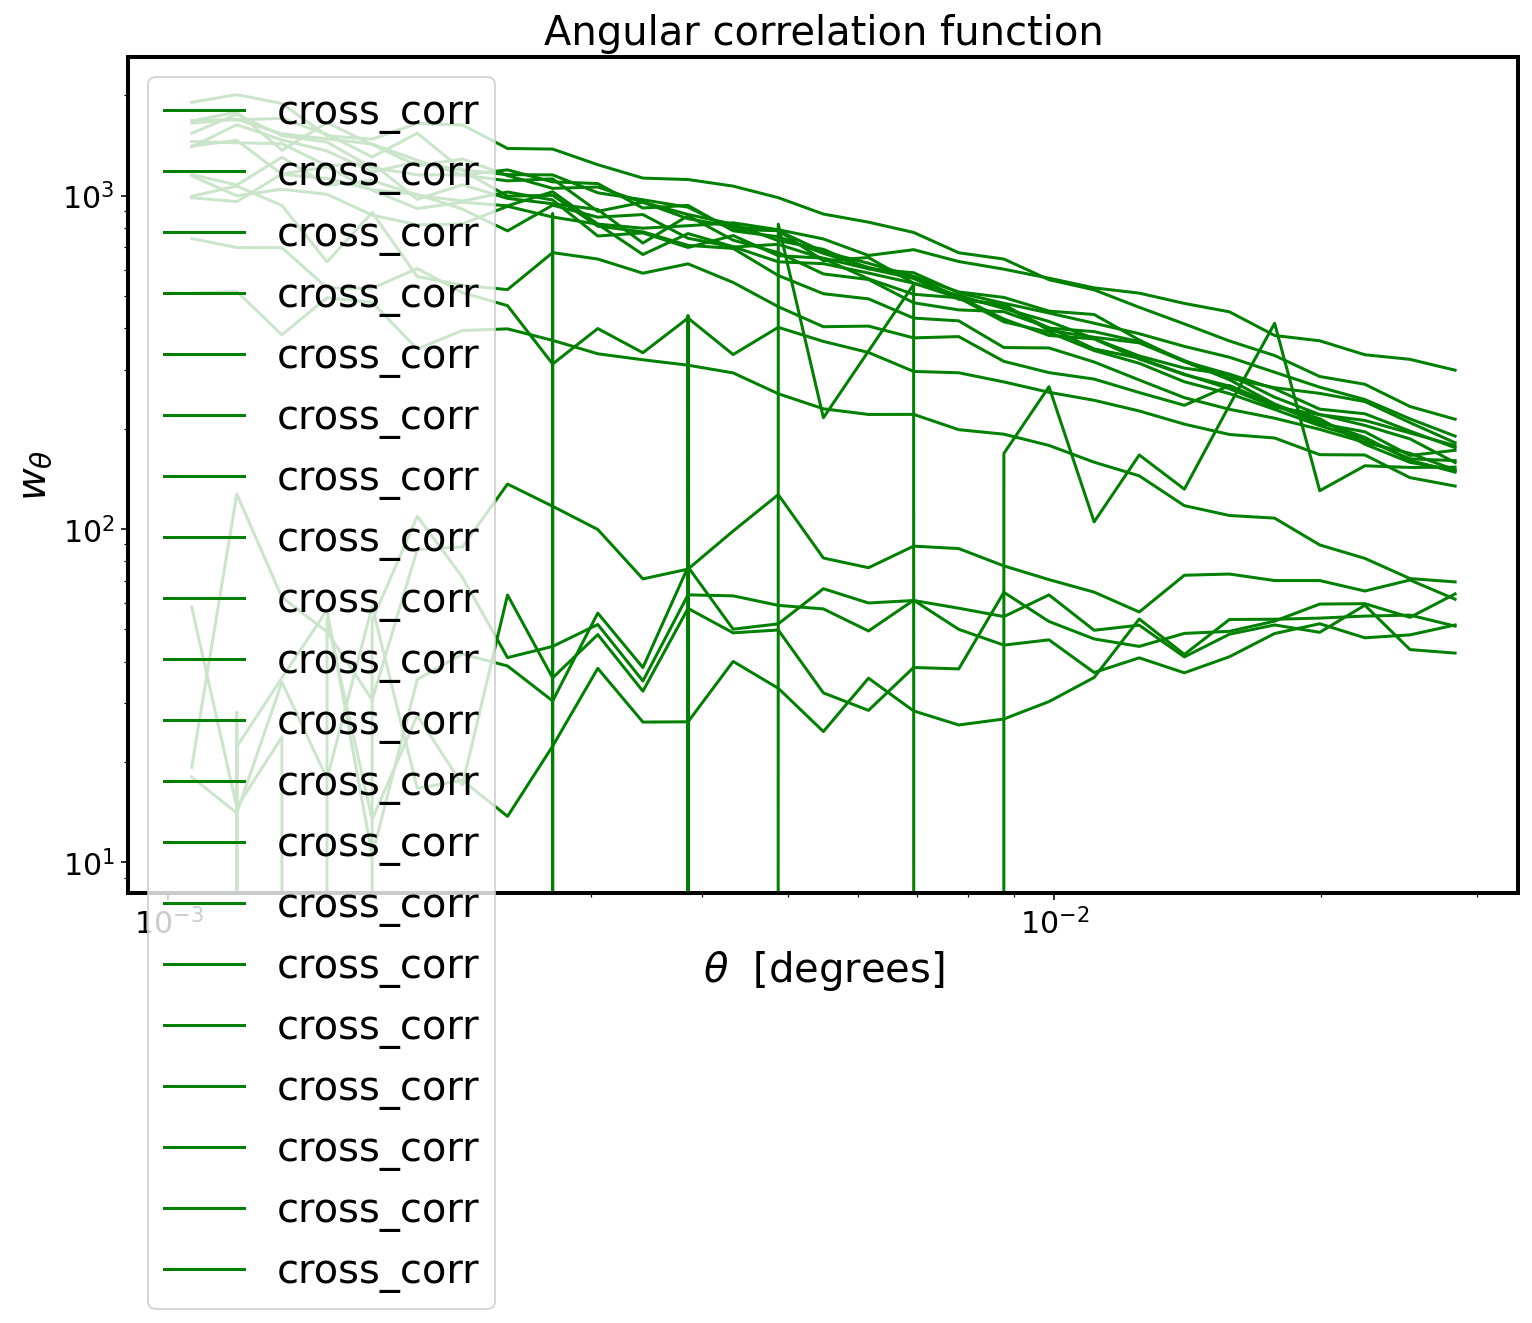

In [46]:
theta_bins = np.logspace(-3,-1.522878745,30)
#redshift_bins = np.arange(0.015,0.315,0.015)
#print(redshift_bins)

cen_theta_bins = (theta_bins[:-1]+theta_bins[1:])/2.0

#tmp_halos = tmp_halos[(tmp_halos['ra_gal']>0) & (tmp_halos['dec_gal']>0)]
#RA1 = tmp_halos['ra_gal'][:]
#DEC1 = -tmp_halos['dec_gal'][:] + 90
N1 = DEC1.shape[0]

for redshift in np.arange(0.07,0.37,0.015):
    halos_mask = (halos['z_cgal_v']>=(redshift-.015)) & (halos['z_cgal_v']<redshift)
    tmp_halos = halos[halos_mask]
    tmp_halos = tmp_halos[(tmp_halos['ra_gal']>0) & (tmp_halos['dec_gal']>0)]
    #print(tmp_halos['z_cgal'])
    RA1 = tmp_halos['ra_gal'][:]
    DEC1 = -tmp_halos['dec_gal'][:] + 90
    angular_coords1 = np.vstack((RA1,DEC1)).T
    #print(angular_coords1)
    
    
    ###################### VERY COOL AND GOOD TPCF ####################
    w_theta12 = angular_tpcf(angular_coords1, theta_bins, sample2=angular_coords2, num_threads='max', do_auto=False, do_cross=True)
    ###################### VERY COOL AND GOOD TPCF ####################
    
    
    ###################### PLOT EVERYTHING ############################
    plt.plot(cen_theta_bins,w_theta12,'-', color='green',
         label = r'cross_corr')
    plt.loglog()
    plt.ylabel(r'$w_{\theta}$', fontsize=20)
    plt.xlabel(r'$\theta$  $[{\rm degrees}]$', fontsize=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.title('Angular correlation function', fontsize=20)
    plt.legend(loc='best', fontsize=20)



tmp_gws = tmp_gws[(tmp_gws['ra_gal']>0) & (tmp_gws['dec_gal']>0)]
RA2 = tmp_gws['ra_gal'][:]
DEC2 = -tmp_gws['dec_gal'][:] + 90
N2 = DEC2.shape[0]

t_s = time.time()
#angular_coords1 = np.vstack((RA1,DEC1)).T
angular_coords2 = np.vstack((RA2,DEC2)).T

#w_theta12 = angular_tpcf(angular_coords1, theta_bins, sample2=angular_coords2, num_threads='max', do_auto=False, do_cross=True)
t_tmp = time.time() - t_s
print('computation took {0} seconds'.format(t_tmp))
#print(theta_bins)
#print(cen_theta_bins)
#print(w_theta12)
#print(np.mean(w_theta12))